In [1]:
%matplotlib notebook
import rospy
from visualization_msgs.msg import MarkerArray
from visualization_msgs.msg import Marker
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import pickle
import numpy as np
from utils import order, compute_inner_inequalities, compute_inner_vertices
import visvalingamwyatt as vw 
from time import perf_counter as clock
from enum import Enum
from scipy.spatial import ConvexHull
import Tess
from scipy.spatial import distance 
from shapely.geometry import Polygon 
import sl1m.tools.plot_tools as plot
from example_robot_data.robots_loader import ANYmalLoader

#load Marker array class example from ROS simulation
fileObject = "/home/thomas_cbrs/Desktop/edin/sl1m_integration_memmo/example_marker_array.pickle"

with open(fileObject, 'rb') as file2:
    array_markers = pickle.load(file2)

Plot surfaces given given by MarkerArray topic, no processing.

<IPython.core.display.Javascript object>


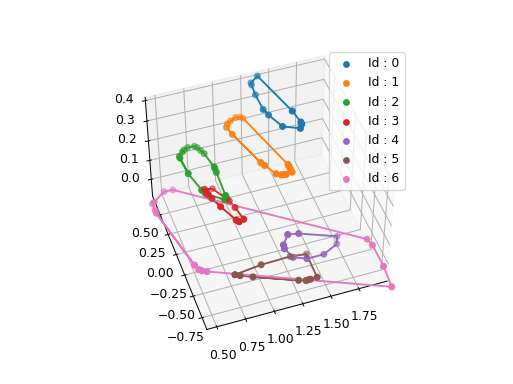

<Axes3DSubplot:>

In [2]:
def plot_marker_surface(array_marker, ax=None):
    """ PLot the edges and vertices from arrayMarker data type.
    
    Args:
        - markerArray (list): The initial input list, containing marker objects.
    """
    if ax is None:
        plt.figure()
        ax = plt.axes(projection="3d")

    for Id, marker in enumerate(array_markers.markers):
        points_ = marker.points
        X = [pt.x for pt in points_]
        Y = [pt.y for pt in points_]
        Z = [pt.z for pt in points_]
        ax.scatter(X, Y, Z, label="Id : " + str(Id))  # Plot 3D points

        X, Y, Z = [], [], []
        X = [pt.x for pt in points_]
        Y = [pt.y for pt in points_]
        Z = [pt.z for pt in points_]
        ax.plot3D(X, Y, Z)  # Plot edges

    ax.legend()
    return ax


plot_marker_surface(array_markers)

Compare different methods to reduce the number of points

<IPython.core.display.Javascript object>


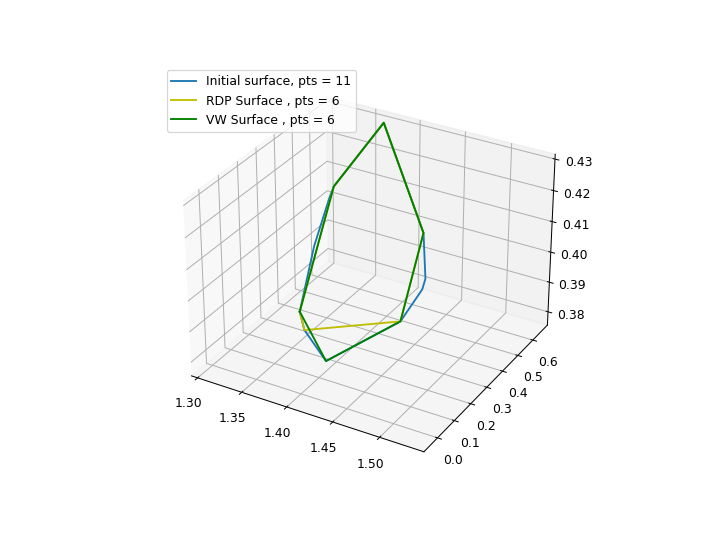

In [3]:
# Compare different methods to reduce the number of points
from rdp import rdp,rdp_iter, rdp_rec

# Initial list
points_ = array_markers.markers[0].points
pts = [[points_[2*k].x, points_[2*k].y,points_[2*k].z] for k in range(int((len(points_)-1 )/ 2))]
pts.append([points_[-1].x, points_[-1].y, points_[-1].z])

# RDP Algo
pts_rdp = rdp(pts, epsilon=0.05) # Cannot tune the final number of points
# VW Algo
simplifier = vw.Simplifier(pts)
pts_vw = simplifier.simplify(number=6).tolist()

# Vizualisation purpose
pts.append([points_[0].x, points_[0].y, points_[0].z]) 
pts_rdp.append(pts_rdp[0])
pts_vw.append(pts_vw[0])

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

X = np.array(pts)[:,0]
Y = np.array(pts)[:,1]
Z = np.array(pts)[:,2]
X_r = np.array(pts_rdp)[:,0]
Y_r = np.array(pts_rdp)[:,1]
Z_r = np.array(pts_rdp)[:,2]
X_v = np.array(pts_vw)[:,0]
Y_v = np.array(pts_vw)[:,1]
Z_v = np.array(pts_vw)[:,2]

ax.plot3D(X,Y,Z, label='Initial surface, pts = ' + str(len(pts)-1))
ax.plot3D(X_r,Y_r,Z_r, label='RDP Surface , pts = ' + str(len(pts_rdp)-1),color ="y")
ax.plot3D(X_v,Y_v,Z_v, label='VW Surface , pts = ' + str(len(pts_vw)-1), color = "g")
ax.legend(loc="upper left")

Extract an inner surface with a margin.

<IPython.core.display.Javascript object>


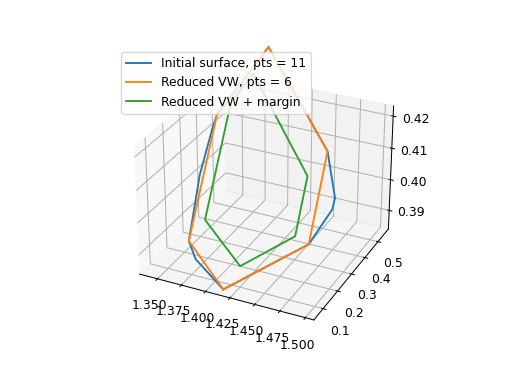

In [4]:
# Prepare surfaces, received from MarkerArray

# Sort the incoming list in list of vertex, example on first array
points_ = array_markers.markers[0].points

# Marker structure :
# [Pt1,Pt2,Pt2,Pt3,Pt3,Pt4, ... , Ptn-1, Ptn, Pt1, Ptn] !Warning order at the end

pts = [[pt.x,pt.y,pt.z] for pt in points_] # List not sorted, with duplicates
vertices = order(np.array(pts))

# Reduce the number of point using Visvalingam’s algorithm 
simplifier = vw.Simplifier(vertices)
vertices_vw = simplifier.simplify(number=6)

margin = 0.02
ineq_inner, ineq_inner_vect, normal = compute_inner_inequalities(vertices_vw, margin)
vertices_inner = compute_inner_vertices(vertices_vw, ineq_inner, ineq_inner_vect )
vertices_inner = order(vertices_inner) # If margin create intersection, need to be sorted

# Plot surfaces
fig = plt.figure()
ax = plt.axes(projection='3d')

vert_inner_list = vertices_inner.tolist()
vert_inner_list.append(vert_inner_list[0])
vert_list = vertices.tolist()
vert_list.append(vertices[0])
vert_vw_list = vertices_vw.tolist()
vert_vw_list.append(vert_vw_list[0])
X = np.array(vert_list)[:,0]
Y = np.array(vert_list)[:,1]
Z = np.array(vert_list)[:,2]
X_r = np.array(vert_inner_list)[:,0]
Y_r = np.array(vert_inner_list)[:,1]
Z_r = np.array(vert_inner_list)[:,2]
X_v = np.array(vert_vw_list)[:,0]
Y_v = np.array(vert_vw_list)[:,1]
Z_v = np.array(vert_vw_list)[:,2]

ax.plot3D(X,Y,Z, label='Initial surface, pts = ' + str(len(vertices)))
ax.plot3D(X_v,Y_v,Z_v, label='Reduced VW, pts = ' + str(len(vertices_vw)))
ax.plot3D(X_r,Y_r,Z_r, label='Reduced VW + margin')
ax.legend(loc="upper left")

Functions to process the surfaces:

In [5]:
def surface_processing(markerArray, margin = 0., n_points = None):
    ''' Process the surfaces list from markerArray data type.
    
    The following method is applied to process each surface:
    1. The vertices received are sorted counterclockwise, duplicates removed.
    2. The number of vertices is reduced using Visvalingam-Wyatt algorithm.
    3. An interior surface is calculated, with a margin parallel to each edge.
    
    Args:
        - markerArray (list): The initial input list, containing marker objects.
        - margin (float): The margin to apply for each edge of the surface.
        - n_points (int or None): The maximal number of vertices for each surface.
                                  None --> No reduction. 
        
    Returns:
        - list : The list the surfaces processed. The surfaces are defined using the vertices positions:
                 array([[x0, x1, ... , xn],
                        [y0, y1, ... , yn],
                        [z0, z1, ... , zn]])    
    '''
    surface_list = []
    # surface_list.append(np.array(init_vertices).T)
    
    for id,marker in enumerate(array_markers.markers) :
        # Marker structure :
        # [Pt1,Pt2,Pt2,Pt3,Pt3,Pt4, ... , Ptn-1, Ptn, Pt1, Ptn] !Warning order at the end
        # if id != 6 :
        pts = [[pt.x,pt.y,pt.z] for pt in marker.points] # List not sorted, with duplicates
        vertices = order(np.array(pts)) # Sorted, no duplicates

        if n_points is None : 
            vertices_vw = vertices

        else :      
            # Reduce the number of point using Visvalingam’s algorithm 
            simplifier = vw.Simplifier(vertices)
            vertices_vw = simplifier.simplify(number=n_points)

        if margin == 0. :                
            vertices_vw = order(vertices_vw)
            surface_list.append(vertices_vw.T)

        else :
            ineq_inner, ineq_inner_vect, normal = compute_inner_inequalities(vertices_vw, margin)
            vertices_inner = compute_inner_vertices(vertices_vw, ineq_inner, ineq_inner_vect )
            vertices_inner = order(vertices_inner) # If margin create intersection, need to be sorted

            surface_list.append(vertices_inner.T)

    return surface_list


def process_tess_results(res, poly_numbers):
    """ Get the surfaces in 2D from tess polygon decomposition.
    
    Args:
        - res (Tess object): Result object from Tess library.
        - poly_numbers (int): Maximum number of vertices for the polygon decomposition.
        
    Returns:
        - List or None:  List of (array 2xn) surfaces defined using the vertices positions:
                      array([[x0, x1, ... , xn],
                             [y0, y1, ... , yn]]).  
    """
    if res.elementCount == 0: 
        return None
    
    vertices_Ids = []
    surfaces = []
    for i in range(res.elementCount):
        list_Id = [id for id in res.elements[poly_numbers*i:poly_numbers*(i+1)] if id != -1]
        vertices_Ids.append(list_Id)
    
    # Get 2D surfaces
    for vertices_Id in vertices_Ids :
        surface = np.zeros((2,len(vertices_Id)))
        for k, Id in enumerate(vertices_Id) :
            surface[0,k] = res.vertices[2*Id]
            surface[1,k] = res.vertices[2*Id+1]
        surfaces.append(surface)
        
    return  surfaces


def get_contour(surface):
    """ Compute the contour of a given surface, projected in X,Y plan. 
    
    Args : 
        - surface (array 3xn):  Surface is defined using the vertices positions:
                                array([[x0, x1, ... , xn],
                                       [y0, y1, ... , yn],
                                       [z0, z1, ... , zn]]).  
    
    Returns :
        - list: The list containing the vertices of the contour line such as 
                          [x0,y0,x1,y1, ... , xn,yn].    
    """
    contour = [] # Contour representation [x0,y0,x1,y1, ... , xn,yn]
    for k in range(surface.shape[1]):
        contour.append(surface[0,k])
        contour.append(surface[1,k])
        
    return contour

def get_Polygon(contour):
    ''' Get Polygon object from a contour.
    
    Args:
        - contour (list): The list containing the vertices of the contour line such as 
                          [x0,y0,x1,y1, ... , xn,yn].
                          
    Returns:
        - Polygon : Polygon class from shapely.geometry. 
    '''
    poly = []

    for k in range(0,len(contour),2):
        poly.append((contour[k],contour[k+1]))
        
    return Polygon(poly)

def get_normal(vertices): 
    """ Compute normal of a surface.
    
    Args: 
        - vertices (array 3xn):  Surface is defined using the vertices positions:
                                array([[x0, x1, ... , xn],
                                       [y0, y1, ... , yn],
                                       [z0, z1, ... , zn]]).  
    
    Returns:
        - array x3: The normal of the surface. 
    """
    # Computes normal surface
    S_normal = np.cross(vertices[:, 0] - vertices[:, 1], vertices[:, 0] - vertices[:, 2])
    if S_normal @ np.array([0., 0., 1.]) < 0.: # Check orientation of the normal
        S_normal = -S_normal
        
    norm =  np.linalg.norm(S_normal)
    if norm > 10e-5 :
        return S_normal / np.linalg.norm(S_normal)
    else:
        return np.array([1.,0.,0.])
   
def projection_surface(vertices2D, equation):
    """ Project an array of 2D vertices (z = 0) inside the surface.

    Returns:
        - array 3xn: The surface is defined using the vertices positions:
                        array([[x0, x1, ... , xn],
                               [y0, y1, ... , yn],
                               [z0, z1, ... , zn]]). 
    """
    if equation[2] < 10e-5:
        raise ValueError('The surface is vertical, cannot project 2D vectors inside.')
    z = (1/equation[2])*(-equation[3] -equation[:2]@vertices2D[:2,:])
    return np.vstack([vertices2D[:2,:], z])

class SurfaceData():
    """Store the data related to a 3D surface.
    """
    
    def __init__(self, vertices, isFloor =False):
        """Initialize the surface data with the vertices positions in 3D.

        Args:
            - vertices (array 3xn): The surface is defined using the vertices positions:
                                    array([[x0, x1, ... , xn],
                                           [y0, y1, ... , yn],
                                           [z0, z1, ... , zn]]). 
        Raises:
            ValueError: If vertice.shape[0] != 3.

        """        
        if vertices.shape[0] != 3:
            raise ValueError('Array should be of size 3xn')
        
        self.vertices = vertices  # Initial 3D surface
        self.h_mean = self._compute_height(vertices)  # Mean height of the surface
        self.normal = self._compute_normal(vertices)
        self.equation = self._compute_surface_equation(vertices, self.normal)
        self.contour = get_contour(vertices[:2,:])      
        self.Polygon = get_Polygon(self.contour)
        self.vertices_reshaped2D = None 
        # Flag to get if this surface has been added mannually, 
        # this modify the taking into account in the process.
        self.isFloor = isFloor 
    
    def _compute_surface_equation(self,vertices, normal):
        """ Get surface equation such as ax + by + cz + d = 0.
        
        Returns:
            - array 4x: [a,b,c,d] parameters.
        """
        d = - vertices[:,0] @ normal
        return np.concatenate((normal,d), axis = None)
        
    
    def _compute_height(self,vertices):
        """ Compute mean the mean height of all vertices.
        Returns:
            - float: Mean height.
        """
        return np.mean(vertices[2,:])
    
    def _compute_normal(self,vertices): 
        """ Compute normal of a surface.

        Returns:
            - array x3: The normal of the surface. 
        """
        # Computes normal surface
        S_normal = np.cross(vertices[:, 0] - vertices[:, 1], vertices[:, 0] - vertices[:, 2])
        if S_normal @ np.array([0., 0., 1.]) < 0.: # Check orientation of the normal
            S_normal = -S_normal

        norm =  np.linalg.norm(S_normal)
        if norm > 10e-5 :
            return S_normal / np.linalg.norm(S_normal)
        else:
            return np.array([1.,0.,0.])
        
class DECOMPO_type(Enum):
    BASIC = 0
    AREA = 1
    CONVEX = 2
    AREA_CONVEX = 3
            
def filter_overlay(surfacesIn, polySize = 10, method = 0, min_area= 0., initial_floor=None) :
    """Filter the surfaces. Projection of the surfaces in X,Y plan and reshape them to avoid overlaying 
    using Tesselation algorithm following the method:
    1. Run the list of surfaces starting with the lowest.
    2. Decomposes the lowest surface in set of convex ones by removing the upper surfaces that overlap it.
       (Tesselation algorithm).
       Use one of the 4 methods listed in DECOMPO_type to select/intersect the surfaces. 
    3. Delate surface from the list and continue.
    
    
    --BASIC (0): Intersect the lowest polygon with all the upper polygon that overlay and keep all remaining
                 surfaces.
    --AREA (1): After difference and decomposition with the upper polygons, select only the remining polygon 
                whose area is superior to min_area arg.
    --CONVEX (2): Apply the difference with the convex hull of the upper surfaces that intersect, to avoid 
                  having small surfaces between the upper surfaces.
    --AREA_CONVEX (3): Both 1 and 2 methods.
    
    
    Args:
        - surfaces (list): List of the surface, defined using the vertices positions:
                                array([[x0, x1, ... , xn],
                                       [y0, y1, ... , yn],
                                       [z0, z1, ... , zn]]).  
        - polySize (int): Number of maximum point for convex decomposition.
        - method (int): Strategy to apply for the decomposition.
        - min_area (flat or None): Keep the area 
    
    Returns:
        - (list): List of the surface reshaped, defined using the vertices positions:
                                array([[x0, x1, ... , xn],
                                       [y0, y1, ... , yn],
                                       [z0, z1, ... , zn]]).  
    """
    method_type = DECOMPO_type(method)
    
    surfaces_init = []
    surfaces = []
    contours_intersect = []
    surfaces_intersect = []
    # Format the incoming data with SurfaceData structure.
    # Project on X,Y axis the surface.
    for sf in surfacesIn:
        s = SurfaceData(sf)
        surfaces_init.append(s)
        surfaces.append(s)
    
    initial_floor_data = None
    if initial_floor is not None:
        initial_floor_data = SurfaceData(initial_floor, isFloor=True)
        surfaces_init.append(initial_floor_data)
        surfaces.append(initial_floor_data) 
        

    
    # Run the list of surfaces starting with the lowest.
    while len(surfaces) > 1:
        h_mean = [sf.h_mean for sf in surfaces]
        id_ = np.argmin(h_mean) # Get id of the lowest surface remaining and process it.

        # Get the list of contour that intersect the surface.
        contours_intersect.clear()
        surfaces_intersect.clear()
        
        initial_floor_intersection = False # ONly for convex process
        for i,s_ in enumerate(surfaces):
            if i != id_:
                if surfaces[id_].Polygon.intersects(s_.Polygon):                    
                    if method_type == DECOMPO_type.CONVEX or method_type == DECOMPO_type.AREA_CONVEX:
                        if s_.isFloor :
                            initial_floor_intersection = True
                        else:
                            surfaces_intersect.append(s_)
                        
                    contours_intersect.append(s_.contour)
                        
        if method_type == DECOMPO_type.CONVEX or method_type == DECOMPO_type.AREA_CONVEX:    
            if len(surfaces_intersect) == 1: # No union needed
                contours_intersect.append(surfaces_intersect[0].contour)
            if len(surfaces_intersect) > 1:
                contours_intersect.clear() # Redefine the contour for the difference
                vertices_union = np.zeros((1,2))
                for sf in surfaces_intersect:
                    vertices_union = np.vstack([vertices_union,sf.vertices[:2,:].T])
                convexHUll = ConvexHull(vertices_union[1:,:])
                vert_2D = np.zeros((2,1))
                for j in convexHUll.vertices:
                    vert_2D = np.hstack([vert_2D, convexHUll.points[j,:].reshape((2,1), order = "F")])
        
                contours_intersect.clear()
                contours_intersect = [get_contour(vert_2D[:,1:])]
                if initial_floor_intersection:
                    contours_intersect.append(initial_floor_data.contour)
    
        
        if len(contours_intersect) == 0: # No surface overllaping, keep initial surface.
            surfaces[id_].vertices_reshaped2D = [surfaces[id_].vertices[:2,:]]

        if len(contours_intersect) != 0 : # Surface overllaping, decompose the surface.
            
            res = tess.difference([surfaces[id_].contour],contours_intersect, polySize=polySize)
            surface_processed = process_tess_results(res, polySize) 
            

            if surface_processed is None : # no surface left after intersection.
                surfaces[id_].vertices_reshaped2D = None
            else :
                surfaces[id_].vertices_reshaped2D = surface_processed.copy()


        # Remove the surface processed from the lists.
        surfaces.pop(id_)
    
    # Reshape remaining surface
    surfaces[0].vertices_reshaped2D = [surfaces[0].vertices[:2,:]]
    
    new_surfaces = []
    for sf in surfaces_init:
        if sf.vertices_reshaped2D is not None :
            for vert in sf.vertices_reshaped2D:
                if method_type == DECOMPO_type.AREA or method_type == DECOMPO_type.AREA_CONVEX:
                    # Keep the surface if the area > min_area
                    # Or if the surface has not been decomposed
                    if get_Polygon(get_contour(vert)).area > min_area or len(sf.vertices_reshaped2D) < 1:
                        vert_3D = projection_surface(vert, sf.equation)
                        new_surfaces.append(vert_3D)
                else:
                    vert_3D = projection_surface(vert, sf.equation)
                    new_surfaces.append(vert_3D)
                
    return new_surfaces
        


Plot functions.

In [6]:
def plot_contour(contour, ax = None, color="b"):
    """ Plot a contour surface in 2D. 
    
    Args :
        - contour (list): List containing of the vertices of the contour line such as 
                          [x0,y0,x1,y1, ... , xn,yn]        
        - ax (ax): Pyplot axe object
        - color (str): Color of the edges.
        
    Returns :
        - ax: Pyplot object
    """
    if ax is None :
        fig = plt.figure()
        ax = plt.axes()
    
    cont_arr = np.array(contour).reshape(2,int(len(contour)/2),order="F")
    
    xs = np.append(cont_arr[0, :], cont_arr[0, 0]).tolist()
    ys = np.append(cont_arr[1, :], cont_arr[1, 0]).tolist()
    ax.plot(xs,ys,color=color)
    
    return ax

def plot_surface2D(surface, ax = None, color="b"):
    """ Plot 2D surface.
    
    Args:
        - surface (array 2xn): 2D surface defined using the vertices positions:
                               array([[x0, x1, ... , xn],
                                      [y0, y1, ... , yn]]).  
        - ax (ax): Pyplot axe object
        - color (str): Color of the edges.
        
    Returns :
        - ax: Pyplot object
    """
    if ax is None :
        fig = plt.figure()
        ax = plt.axes()
    
    xs = np.append(surface[0, :], surface[0, 0]).tolist()
    ys = np.append(surface[1, :], surface[1, 0]).tolist()
    ax.plot(xs, ys, color= color)
    
    return ax

Exemple of Tess algorithm :
from https://github.com/azrafe7/hxGeomAlgo

Run took [ms]:  3.1771619978826493


<IPython.core.display.Javascript object>


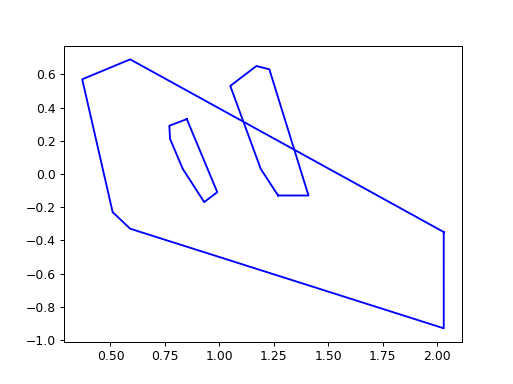

<IPython.core.display.Javascript object>


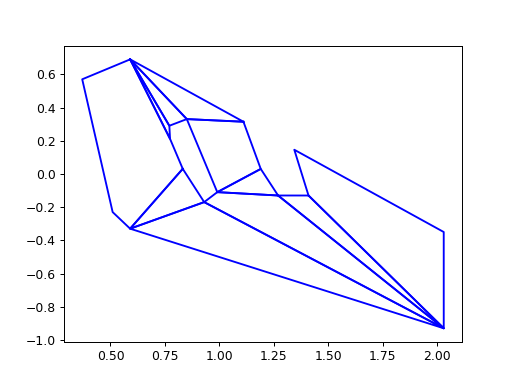

In [7]:
all_surfaces = surface_processing(array_markers, margin = 0.0, n_points=6)

#Projection on Z axis
ca = get_contour(all_surfaces[6])
cb = get_contour(all_surfaces[1])
cc = get_contour(all_surfaces[3])

polySize = 10
tess = Tess.hxGeomAlgo_Tess2()
t0 = clock()
res = tess.difference([ca],[cb,cc], polySize=polySize)
surfaces = process_tess_results(res, polySize)
t1 = clock()
print("Run took [ms]: ", 1000. * (t1-t0))

#Plot contours
ax = plot_contour(ca)
plot_contour(cb, ax)
plot_contour(cc, ax)

# Plot results
fig = plt.figure()
ax = plt.axes()
for i,sf in enumerate(surfaces) :
    plot_surface2D(sf, ax=ax)


Result of the data processing, following this method :

Reduce the incoming surfaces.
1. The vertices received are sorted counterclockwise, duplicates removed.
2. The number of vertices is reduced using Visvalingam-Wyatt algorithm.
3. An interior surface is calculated, with a margin parallel to each edge.

Decomposition and filtering of the surfaces obtain. Projection of the surfaces in X,Y plan and reshape them to avoid overlaying using Tesselation algorithm:
1. Run the list of surfaces starting with the lowest.
2. Decomposes the lowest surface in set of convex ones by removing the upper surfaces that overlap it.
   (Tesselation algorithm).
   Use one of the 4 methods listed in DECOMPO_type to select/intersect the surfaces. 
3. Delate surface from the list and continue.

<IPython.core.display.Javascript object>


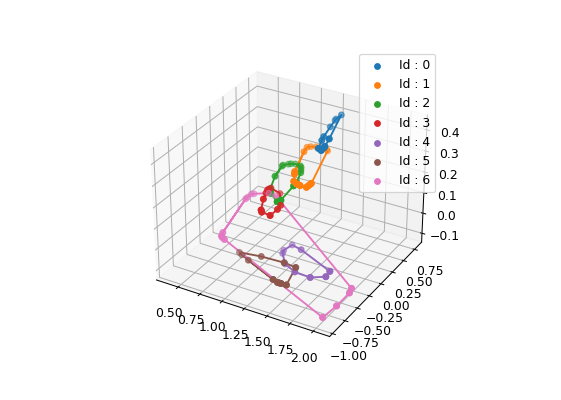

<IPython.core.display.Javascript object>


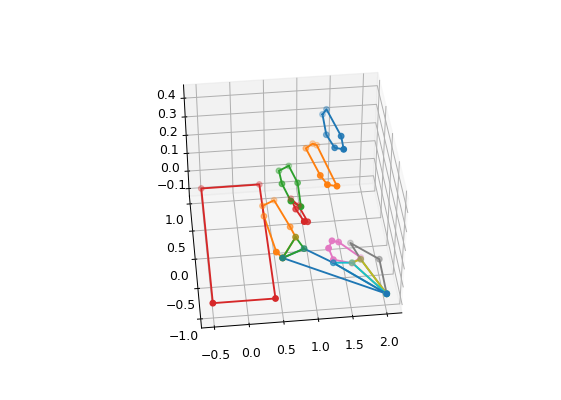

In [13]:
# PLot initial surfaces
fig = plt.figure(figsize=(7, 5))
ax = plt.axes(projection="3d")
plot_marker_surface(array_markers, ax)

# Add initial surface
h_init = -0.06
init_vertices = np.array([[0.4, -1, h_init],[0.4,1.,h_init],[-0.5,1.,h_init],[-0.5,-1,h_init]])



# PARAMETERS FOR SURFACES PROCESSING 
margin = 0.
n_points = 6
method_id = 3
polySize = 10
min_area = 0.03

# Reduce and sort incoming data
all_surfaces = surface_processing(array_markers, margin=margin, n_points=n_points)

# Apply proccess to filter and decompose the surfaces
g = filter_overlay(all_surfaces, polySize=polySize, method=method_id, min_area=min_area, initial_floor=init_vertices.T)


# Plot process result
plt.figure(figsize=(7, 5))
ax = plt.axes(projection='3d')
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
         '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i,sf in enumerate(g):
    plot.plot_surface(sf,ax=ax, color_id=i )
    ax.scatter(sf[0,:],sf[1,:],sf[2,:], color=COLORS[i % len(COLORS)])

SL1M functions

In [73]:
def get_potential_surfaces( configs, gait, all_surfaces):
    """
    Get the rotation matrix and surface condidates for each configuration in configs
    :param configs: a list of successive configurations of the robot
    :param gait: a gait matrix
    :return: a list of surface candidates
    """
    surfaces_list = []
    empty_list = False
    for id, config in enumerate(configs):
        foot_surfaces = []
        stance_feet = np.nonzero(gait[id % len(gait)] == 1)[0]
        previous_swing_feet = np.nonzero(gait[(id-1) % len(gait)] == 0)[0]
        moving_feet = stance_feet[np.in1d(stance_feet, previous_swing_feet, assume_unique=True)]

        foot_surfaces.append(all_surfaces)
        surfaces_list.append(foot_surfaces)

    return surfaces_list, empty_list
    
def compute_com_positions(configs,pb):
    """
    Compute the com positions
    :param configs the list of configurations
    """
    com_positions = []
    for phase in pb.phaseData:
        com = configs[phase.id][:3]
        # com[2] += 0.5
        com_positions.append(configs[phase.id][:3])

    return com_positions

def compute_effector_positions(configs, bvref, pb):
    """
    Compute the desired effector positions
    :param configs the list of configurations
    :param bvref, Array (x3) the desired velocity in base frame
    """
    # TODO: Divide by number of phases in gait
    t_stance = T_gait/2
    effector_positions = np.zeros((4, pb.n_phases, 2))

    for phase in pb.phaseData:
        for foot in phase.moving:
            rpy = pin.rpy.matrixToRpy(pin.Quaternion(np.array(configs[phase.id][3:7])).toRotationMatrix())
            yaw = rpy[2]  # Get yaw for the predicted configuration
            shoulders = np.zeros(2)
            # Compute heuristic position in horizontal frame
            rpy[2] = 0.  # Yaw = 0. in horizontal frame
            Rp = pin.rpy.rpyToMatrix(rpy)[:2, :2]
            heuristic = 0.5 * t_stance * Rp @ bvref[:2] + Rp @ offsets_feet[:2,foot]

            # Compute heuristic in world frame, rotation
            shoulders[0] = heuristic[0] * np.cos(yaw) - heuristic[1] * np.sin(yaw)
            shoulders[1] = heuristic[0] * np.sin(yaw) + heuristic[1] * np.cos(yaw)
            effector_positions[foot][phase.id] = np.array(configs[phase.id][:2] + shoulders)

    return effector_positions

def retrieve_surfaces(surfaces, pb, indices=None):
        """
        Get the surface vertices, inequalities and selected surface indices if need be
        """
        vertices = []
        surfaces_inequalities = []
        if indices is not None:
            surface_indices = []
        else:
            surface_indices = None
        first_phase_i = 0
        second_phase_i = 0
        for foot in range(4):
            if foot in pb.phaseData[0].moving:
                vertices.append(surfaces[0][first_phase_i])
                surfaces_inequalities.append(pb.phaseData[0].S[first_phase_i])
                if indices is not None:
                    surface_indices.append(indices[0][first_phase_i])
                first_phase_i += 1
            elif foot in pb.phaseData[1].moving:
                vertices.append(surfaces[1][second_phase_i])
                surfaces_inequalities.append(pb.phaseData[1].S[second_phase_i])
                if indices is not None:
                    surface_indices.append(indices[1][second_phase_i])
                second_phase_i += 1
            else:
                pass
#                 print("Error : the foot is not moving in any of the first two phases")

        return vertices, surfaces_inequalities, surface_indices
    

SL1M result on resulting surfaces

In [45]:
from sl1m.problem_definition import Problem
from sl1m.generic_solver import solve_MIP
import os
import pinocchio as pin

# SL1M initialization
paths = [os.environ["INSTALL_HPP_DIR"] + "/anymal-rbprm/com_inequalities/feet_quasi_flat/anymal_",
         os.environ["INSTALL_HPP_DIR"] + "/anymal-rbprm/relative_effector_positions/anymal_"]
suffix_com="_effector_frame_quasi_static_reduced.obj"
limbs = ['LFleg', 'RFleg', 'LHleg', 'RHleg']
others = ['LF_ADAPTER_TO_FOOT', 'RF_ADAPTER_TO_FOOT', 'LH_ADAPTER_TO_FOOT', 'RH_ADAPTER_TO_FOOT']
suffix_feet="_reduced.obj"

ANYmalLoader.free_flyer = True
anymal = ANYmalLoader().robot

pb = Problem(limb_names=limbs, other_names=others, constraint_paths=paths, suffix_com= suffix_com, suffix_feet= suffix_feet)

Import error: No module GLPK
Academic license - for non-commercial use only - expires 2022-09-29
Using license file /home/thomas_cbrs/gurobi.lic
Parameter LogFile unchanged
   Value:   Default: 


/opt/openrobots/lib/python3.8/site-packages/pinocchio/shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


Run total [ms] 5683.742267996422


Run reduce [ms] 9.242556989192963
Run overlay [ms] 11.500690001412295
Run MIP [ms] 5532.822385997861


<IPython.core.display.Javascript object>


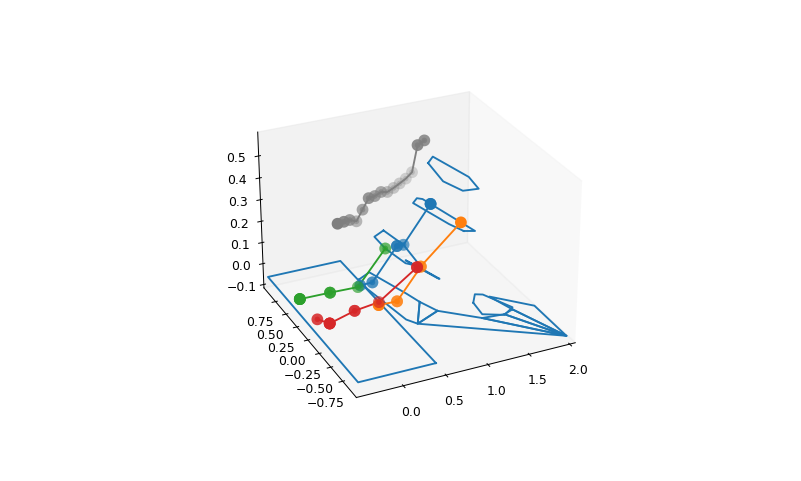

In [82]:
t0_total = clock()

#####################################
# PARAMETERS FOR SURFACES PROCESSING 
#####################################
margin = 0.
n_points = 6
method_id = 3
polySize = 10
min_area = 0.03

# Reduce and sort incoming data
t0_reduce = clock()
surfaces_reduced = surface_processing(array_markers, margin=margin, n_points=n_points)
t1_reduce = clock()

# Apply proccess to filter and decompose the surfaces
t0_overlay = clock()
surfaces_processed = filter_overlay(surfaces_reduced, polySize=polySize, method=method_id, min_area=min_area, initial_floor=init_vertices.T)
t1_overlay = clock()

##################
# WALK PARAMETERS
##################
# Walking gait 
gait = np.array([[0.,1.,1.,1.],
                 [1.,0.,1.,1.],
                 [1.,1.,0.,1.],
                 [1.,1.,1.,0.]])
T_gait = 2.
n_gait = 4 # Number of different phases in the gait
N_phase = 15 # Number of phases
bvref = np.array([0.15,0.,0.]) # Reference velocity
initial_config = np.array([0.,0.3,0.,0.,0.,0.,1.]) # Initial config

# Get Anymal feet offset
pin.centerOfMass(anymal.model, anymal.data, anymal.q0)
pin.updateFramePlacements(anymal.model, anymal.data)
pin.crba(anymal.model, anymal.data, anymal.q0)
    
indexes = ['LF_FOOT', 'RF_FOOT', 'LH_FOOT', 'RH_FOOT']
offsets_feet = np.zeros((3,4))
for i,idx in enumerate(indexes) :
    Id = anymal.model.getFrameId(idx)
    offsets_feet[:,i] = anymal.data.oMf[Id].translation


# Initialisation of model quantities
q = anymal.q0.copy()
q[:3] = initial_config[:3]
pin.centerOfMass(anymal.model, anymal.data, q)
pin.updateFramePlacements(anymal.model, anymal.data)
pin.crba(anymal.model, anymal.data, q)
current_contacts = np.zeros((3,4))
for i,idx in enumerate(indexes) :
    Id = anymal.model.getFrameId(idx)
    current_contacts[:,i] = anymal.data.oMf[Id].translation
current_contacts[2,:] = h_init

configs = []
configs.append(initial_config.tolist())
for i in range(1,N_phase):
    config = np.zeros(7)
    config[:3] = bvref*(T_gait/n_gait)*i + initial_config[:3]
    rpy = np.array([0.,0.,0.])
    config[3:] = pin.Quaternion(pin.rpy.rpyToMatrix(rpy)).coeffs()
    configs.append(config.tolist())

R = [pin.XYZQUATToSE3(np.array(config)).rotation for config in configs]

initial_contacts = [np.array(current_contacts[:, i].tolist()) for i in range(4)]


surfaces, empty_list = get_potential_surfaces(configs, gait, surfaces_processed)

# Without CoM optimization
# costs = {"effector_positions": [1.0, effector_positions]}
# pb.generate_problem(R, surfaces, gait, initial_contacts, c0=None,  com=False)

# # With CoM optimization
pb.generate_problem(R, surfaces, gait, initial_contacts, configs[0][:3],  com=True)

# Generate costs
com_positions = compute_com_positions(configs, pb)
effector_positions = compute_effector_positions(configs, bvref,pb)
costs = { "effector_positions": [10.0, effector_positions] ,"coms_3D": [0.1,com_positions]}

t0_MIP = clock()
pb_data = solve_MIP(pb, costs=costs,  com=True)
t1_MIP = clock()


# Process result SL1M
if pb_data.success:
    surface_indices = pb_data.surface_indices
    vertices, inequalities, indices = retrieve_surfaces(surfaces, pb, surface_indices)

else:
    print("The MIP problem did NOT converge")
    vertices, inequalities, indices = retrieve_surfaces(surfaces, pb)

t1_total = clock()
print("Run total [ms]", 1000. * (t1_total - t0_total))
print("\n")
print("Run reduce [ms]", 1000. * (t1_reduce - t0_reduce))
print("Run overlay [ms]", 1000. * (t1_overlay - t0_overlay))
print("Run MIP [ms]", 1000. * (t1_MIP - t0_MIP))
# Plot 3D
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
for sf in surfaces_processed :
    plot.plot_surface(sf,ax=ax)
plot.plot_planner_result(pb_data.all_feet_pos, coms=pb_data.coms, ax=ax, show=True)

[[11],
 [9],
 [9],
 [11],
 [11],
 [2],
 [2],
 [11],
 [11],
 [2],
 [2],
 [2],
 [3],
 [1],
 [1]]